In [1]:
import wfdb
import csv
import pandas as pd
import numpy as np
import os

In [2]:
import os
import csv
import pandas as pd
import wfdb  # Make sure wfdb is installed

output_dir = "data_creation"
os.makedirs(output_dir, exist_ok=True)

# Patient numbers
patient_numbers = [
    "100", "101", "102", "103", "104", "105", "106", "107", "108", "109",
    "111", "112", "113", "114", "115", "116", "117", "118", "119", "121",
    "122", "123", "124", "200", "201", "202", "203", "205", "207", "208",
    "209", "210", "212", "213", "214", "215", "217", "219", "220", "221",
    "222", "223", "228", "230", "231", "232", "233", "234"
]

# N = normal 
# S = supra-ventricular premature
# V = ventricular escape
# F = fusion of ventricular and normal
# Q = unclassified heartbeats
symbol_to_category = {
    'N': 'N', '.': 'N', 'L': 'N', 'R': 'N', 'e': 'N', 'j': 'N',
    'a': 'S', 'A': 'S', 'J': 'S', 'S': 'S',
    'V': 'V', 'E': 'V',
    'F': 'F',
    '/': 'Q', 'f': 'Q', 'Q': 'Q'
}

for patient_number in patient_numbers:
    try:
        # ECG data
        path_to_record = f"mit-database/{patient_number}"
        patient_record = wfdb.rdrecord(path_to_record)
        leads = patient_record.sig_name
        ecg_data = patient_record.p_signal

        # ECG CSV
        ecg_filename = f"{output_dir}/{patient_number}_ECG.csv"
        with open(ecg_filename, "w", newline='') as outfile:
            out_csv = csv.writer(outfile)
            out_csv.writerow(leads)
            for row in ecg_data:
                out_csv.writerow(row)

        # Annotations data
        annotation = wfdb.rdann(path_to_record, 'atr')
        symbols = annotation.symbol
        annotations = annotation.sample

        # Filter out symbols not in symbol_to_category
        filtered_symbols_annotations = [(sym, ann) for sym, ann in zip(symbols, annotations) if sym in symbol_to_category]
        categories = [symbol_to_category[sym] for sym, ann in filtered_symbols_annotations]
        annotations_filtered = [ann for sym, ann in filtered_symbols_annotations]

        df_annotations = pd.DataFrame({'Category': categories, 'Annotation': annotations_filtered})

        # Annotations CSV
        annotations_filename = f"{output_dir}/{patient_number}_Annotations.csv"
        df_annotations.to_csv(annotations_filename, index=False)

    except Exception as e:
        print(f"Failed to process: {patient_number}: {e}")

print("Done")

Done


In [3]:
def process_patient_data(patient_number, data_creation_dir="data_creation"):

    ecg_file_path = os.path.join(data_creation_dir, f"{patient_number}_ECG.csv")
    annotations_file_path = os.path.join(data_creation_dir, f"{patient_number}_Annotations.csv")
    
    patient_X = []
    patient_Y = []
    
    try:
        ecg_df = pd.read_csv(ecg_file_path)
        annotations_df = pd.read_csv(annotations_file_path)
    except FileNotFoundError:
        print(f"Files for patient {patient_number} not found. Skipping...")
        return [], []
    
    first_column_name = ecg_df.columns[0]

    sampling_rate = 360  # Hz
    window_size_seconds = 2  # Seconds before and after annotation
    window_size_samples = window_size_seconds * sampling_rate

    for _, row in annotations_df.iterrows():
        annotation_point = row['Annotation']
        category = row['Category']
        
        start_point = max(0, annotation_point - window_size_samples)
        end_point = min(len(ecg_df), annotation_point + window_size_samples)
        
        window_data = ecg_df.iloc[start_point:end_point][first_column_name].to_numpy()
        if len(window_data) < window_size_samples * 2:
            window_data = np.pad(window_data, (0, window_size_samples * 2 - len(window_data)), 'constant')
        
        patient_X.append(window_data)
        patient_Y.append(category)
    
    return patient_X, patient_Y

# Initialize lists to hold the entire dataset
all_X = []
all_Y = []

data_creation_dir = "data_creation"

# Process each patient
for patient_number in patient_numbers:
    patient_X, patient_Y = process_patient_data(patient_number, data_creation_dir)
    all_X.extend(patient_X)
    all_Y.extend(patient_Y)

X = np.array(all_X)
Y = np.array(all_Y)

In [4]:
X

array([[-0.145, -0.145, -0.145, ...,  0.   ,  0.   ,  0.   ],
       [-0.145, -0.145, -0.145, ...,  0.   ,  0.   ,  0.   ],
       [-0.145, -0.145, -0.145, ...,  0.   ,  0.   ,  0.   ],
       ...,
       [-0.31 , -0.335, -0.35 , ...,  0.   ,  0.   ,  0.   ],
       [-0.34 , -0.34 , -0.34 , ...,  0.   ,  0.   ,  0.   ],
       [-0.28 , -0.27 , -0.275, ...,  0.   ,  0.   ,  0.   ]])

In [5]:
Y

array(['N', 'N', 'N', ..., 'N', 'N', 'N'], dtype='<U1')

In [6]:
df_x = pd.DataFrame(X)
df_x

,0,1,2,3,4,5,6,7,8,9,...,1430,1431,1432,1433,1434,1435,1436,1437,1438,1439
0,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.120,-0.135,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.120,-0.135,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.120,-0.135,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,-0.280,-0.290,-0.275,-0.270,-0.260,-0.280,-0.280,-0.285,-0.275,-0.275,...,-0.275,-0.275,-0.290,-0.295,-0.305,-0.295,-0.295,-0.285,-0.290,-0.300
4,-0.305,-0.315,-0.305,-0.315,-0.315,-0.310,-0.295,-0.290,-0.305,-0.310,...,-0.285,-0.290,-0.290,-0.280,-0.280,-0.285,-0.290,-0.300,-0.295,-0.285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109489,-0.090,-0.255,-0.355,-0.380,-0.345,-0.315,-0.290,-0.305,-0.330,-0.365,...,-0.255,-0.260,-0.265,-0.270,-0.260,-0.265,-0.275,-0.290,-0.280,-0.285
109490,0.695,0.355,0.060,-0.180,-0.310,-0.370,-0.380,-0.365,-0.350,-0.335,...,-0.270,-0.280,-0.290,-0.300,-0.295,-0.280,-0.305,-0.295,-0.290,-0.280
109491,-0.310,-0.335,-0.350,-0.375,-0.415,-0.430,-0.435,-0.425,-0.420,-0.410,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
109492,-0.340,-0.340,-0.340,-0.350,-0.365,-0.365,-0.360,-0.350,-0.335,-0.335,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [7]:
df_y = pd.DataFrame(Y, columns=['ColumnName'])
print(df_y)

       ColumnName
0               N
1               N
2               N
3               N
4               N
...           ...
109489          N
109490          N
109491          N
109492          N
109493          N

[109494 rows x 1 columns]


In [8]:
value_counts_y = df_y['ColumnName'].value_counts()
print(value_counts_y)

ColumnName
N    90631
Q     8043
V     7236
S     2781
F      803
Name: count, dtype: int64


In [9]:
df_fusionné = pd.concat([df_y, df_x], axis=1)
df_fusionné

,ColumnName,0,1,2,3,4,5,6,7,8,...,1430,1431,1432,1433,1434,1435,1436,1437,1438,1439
0,N,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.120,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,N,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.120,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,N,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.120,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,N,-0.280,-0.290,-0.275,-0.270,-0.260,-0.280,-0.280,-0.285,-0.275,...,-0.275,-0.275,-0.290,-0.295,-0.305,-0.295,-0.295,-0.285,-0.290,-0.300
4,N,-0.305,-0.315,-0.305,-0.315,-0.315,-0.310,-0.295,-0.290,-0.305,...,-0.285,-0.290,-0.290,-0.280,-0.280,-0.285,-0.290,-0.300,-0.295,-0.285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109489,N,-0.090,-0.255,-0.355,-0.380,-0.345,-0.315,-0.290,-0.305,-0.330,...,-0.255,-0.260,-0.265,-0.270,-0.260,-0.265,-0.275,-0.290,-0.280,-0.285
109490,N,0.695,0.355,0.060,-0.180,-0.310,-0.370,-0.380,-0.365,-0.350,...,-0.270,-0.280,-0.290,-0.300,-0.295,-0.280,-0.305,-0.295,-0.290,-0.280
109491,N,-0.310,-0.335,-0.350,-0.375,-0.415,-0.430,-0.435,-0.425,-0.420,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
109492,N,-0.340,-0.340,-0.340,-0.350,-0.365,-0.365,-0.360,-0.350,-0.335,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [13]:
line = df_fusionné.loc[df_fusionné['ColumnName'] == 'Q']
line

,ColumnName,0,1,2,3,4,5,6,7,8,...,1430,1431,1432,1433,1434,1435,1436,1437,1438,1439
2633,Q,1.405,1.185,0.875,0.580,0.350,0.225,0.160,0.095,-0.035,...,0.525,0.575,0.655,0.665,0.645,0.620,0.630,0.640,0.645,0.635
3172,Q,-0.325,-0.325,-0.315,-0.325,-0.330,-0.335,-0.320,-0.315,-0.320,...,-0.455,-0.425,-0.430,-0.440,-0.440,-0.460,-0.485,-0.520,-0.510,-0.505
4138,Q,-0.200,-0.200,-0.200,-0.200,-0.200,-0.200,-0.200,-0.200,-0.190,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4139,Q,-0.200,-0.200,-0.200,-0.200,-0.200,-0.200,-0.200,-0.200,-0.190,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4140,Q,-0.200,-0.200,-0.200,-0.200,-0.200,-0.200,-0.200,-0.200,-0.190,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84280,Q,-0.185,-0.210,-0.215,-0.230,-0.250,-0.245,-0.255,-0.275,-0.285,...,0.275,0.310,0.335,0.360,0.375,0.380,0.390,0.415,0.445,0.495
84281,Q,-0.220,-0.225,-0.250,-0.265,-0.270,-0.260,-0.250,-0.255,-0.265,...,0.150,0.140,0.160,0.190,0.225,0.240,0.240,0.250,0.270,0.310
84282,Q,-0.260,-0.260,-0.255,-0.240,-0.255,-0.275,-0.285,-0.305,-0.300,...,0.245,0.260,0.280,0.285,0.290,0.305,0.340,0.380,0.400,0.420
84283,Q,-0.370,-0.365,-0.385,-0.370,-0.370,-0.350,-0.340,-0.345,-0.355,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


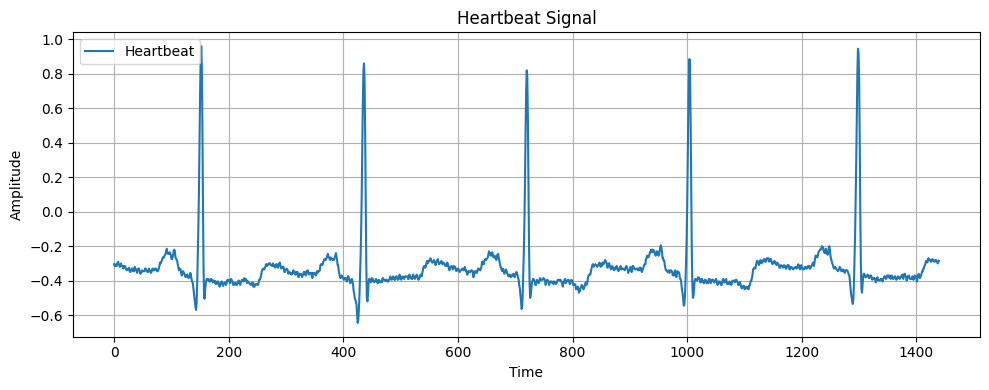

In [15]:
import matplotlib.pyplot as plt
import numpy as np

heartbeat_values = df_fusionné.iloc[4,1:]
heartbeat_values
# Creating a time axis for the 3600 points, assuming each point represents a unit of time
time_axis = np.arange(0, 1440)

# Plotting the heartbeat
plt.figure(figsize=(10, 4))
plt.plot(time_axis, heartbeat_values, label='Heartbeat')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Heartbeat Signal')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

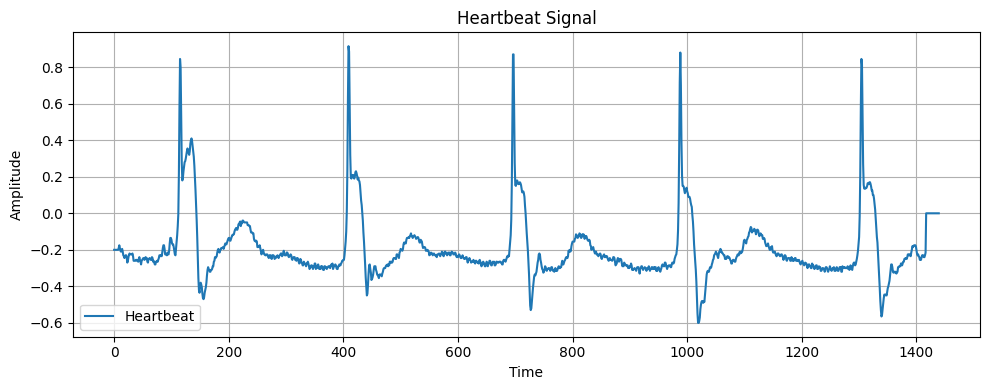

In [14]:
import matplotlib.pyplot as plt
import numpy as np

heartbeat_values = df_fusionné.iloc[4140,1:]
heartbeat_values
# Creating a time axis for the 3600 points, assuming each point represents a unit of time
time_axis = np.arange(0, 1440)

# Plotting the heartbeat
plt.figure(figsize=(10, 4))
plt.plot(time_axis, heartbeat_values, label='Heartbeat')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Heartbeat Signal')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
# df_fusionné.to_csv('df_fusionné.csv', index=False)